In [1]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
#!pip install scikit-elm
from skelm import ELMClassifier
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("Group_4_data_cleaned.csv",index_col=0)
df.head()

,height,length,area,eccen,p_black,p_and,mean_tr,blackpix,blackand,wb_trans,y
0,5.0,7,35,1.400,0.400,0.657,2.33,14,23.0,6.0,1
1,6.0,7,42,1.167,0.429,0.881,3.60,18,37.0,5.0,1
2,6.0,18,108,3.000,0.287,0.741,4.43,31,80.0,7.0,1
3,5.0,7,35,1.400,0.371,0.743,4.33,13,26.0,3.0,1
4,6.0,3,18,0.500,0.500,0.944,2.25,9,17.0,4.0,1


In [3]:
print(df.describe())
print(df.info())

            height       length         area        eccen      p_black  \
count  5473.000000  5473.000000  5473.000000  5473.000000  5473.000000   
mean      8.491778    75.944089   678.280833     9.422260     0.355031   
std       2.958167    77.844052   760.273682     9.661801     0.139284   
min       2.500000     1.000000     7.000000     0.007000     0.052000   
25%       7.000000    17.000000   114.000000     2.143000     0.261000   
50%       8.000000    41.000000   322.000000     5.167000     0.337000   
75%      10.000000   107.000000   980.000000    13.625000     0.426000   
max      14.500000   242.000000  2279.000000    30.848000     0.673500   

             p_and      mean_tr     blackpix     blackand     wb_trans  \
count  5473.000000  5473.000000  5473.000000  5473.000000  5473.000000   
mean      0.786324     2.578667   198.322310   492.037365    86.901242   
std       0.166482     1.310313   208.242346   532.593288    92.165275   
min       0.307000     1.000000     7

In [4]:
output_dict={1:'text',2:'horizontal line',3:'picture',4:'vertical line',5:'graphic'}
df["y"].value_counts().rename(index=output_dict)

text               4913
horizontal line     329
graphic             115
vertical line        88
picture              28
Name: y, dtype: int64

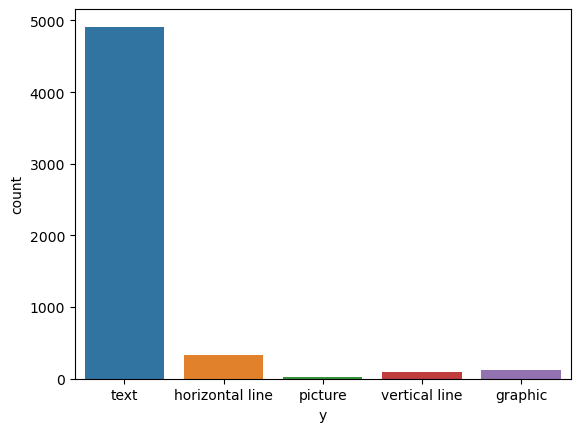

In [5]:
ax=sns.countplot(df['y'])
ax.set(xticklabels=output_dict.values())
plt.show()

In [6]:
X=df.iloc[:, :-1]
y=df['y']

oversampler = RandomOverSampler(random_state=42)
X, y = oversampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Define the four classifiers with best parameters
c1 = Pipeline([('scaler', MinMaxScaler()), ('sgd', SGDClassifier(tol=0.0001, penalty='l1', loss='hinge', learning_rate='optimal', eta0=0.1, alpha=0.0001))])
c2 = KNeighborsClassifier(n_neighbors=3, p=2, weights='uniform')
c3 = RandomForestClassifier(max_depth=50, n_estimators=30, random_state=42, max_features="log2")
c4 = SVC(kernel='rbf', C=10, gamma=1)
c5 = ELMClassifier(alpha=0.001, n_neurons=512, ufunc='relu')
c6 = SVC(kernel="poly",degree=3)
c7 = MLPClassifier(solver = 'adam', learning_rate='constant', hidden_layer_sizes= 200, alpha = 0.001, activation='relu')

In [8]:
# Create an ensemble model using voting
e_model = VotingClassifier(estimators=[('sgd', c1), ('knn', c2),
                                       ('rf', c3),('svm', c4),
                                       ('elm', c5),
                                       ('svcpoly', c6),
                                       ('mlp_classifier', c7)], voting = 'hard')

In [9]:
# Train the ensemble model on the training data
e_model.fit(X_train, y_train)

VotingClassifier(estimators=[('sgd',
                              Pipeline(steps=[('scaler', MinMaxScaler()),
                                              ('sgd',
                                               SGDClassifier(eta0=0.1,
                                                             penalty='l1',
                                                             tol=0.0001))])),
                             ('knn', KNeighborsClassifier(n_neighbors=3)),
                             ('rf',
                              RandomForestClassifier(max_depth=50,
                                                     max_features='log2',
                                                     n_estimators=30,
                                                     random_state=42)),
                             ('svm', SVC(C=10, gamma=1)),
                             ('elm',
                              ELMClassifier(alpha=0.001, n_neurons=512,
                                            ufunc=

In [10]:
y_pred = e_model.predict(X_test)

In [11]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9906370852839406

In [14]:
cm=confusion_matrix(y_test, y_pred)
cm

array([[970,   6,   4,   3,   7],
       [  6, 975,   0,  10,   0],
       [  0,   0, 968,   0,   0],
       [  0,   0,   0, 975,   0],
       [  0,   0,   0,  10, 979]])

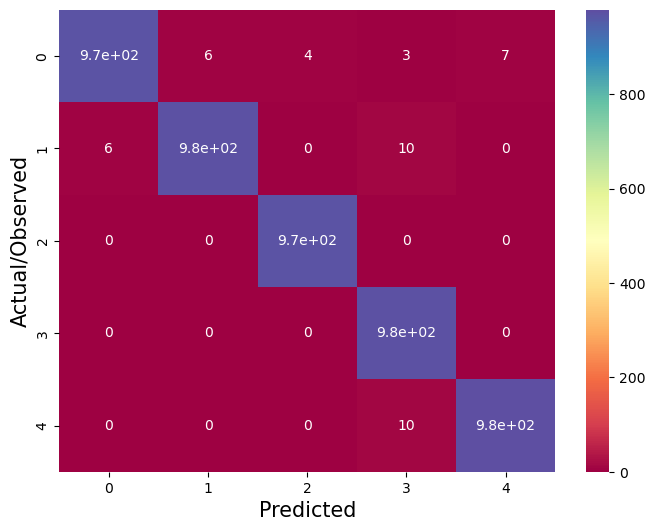

In [15]:
plt.figure(figsize = (8,6))

sns.heatmap(cm, 
            annot=True, 
            cmap="Spectral")
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actual/Observed', fontsize=15);

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.99      0.98      0.99       990
           2       0.99      0.98      0.99       991
           3       1.00      1.00      1.00       968
           4       0.98      1.00      0.99       975
           5       0.99      0.99      0.99       989

    accuracy                           0.99      4913
   macro avg       0.99      0.99      0.99      4913
weighted avg       0.99      0.99      0.99      4913

